**This section of the course requires familiarity with Bayesian inference, which is covered elsewhere in the Vanderbilt Biostatistics graduate program. For an introduction to Bayesian statistics, I recommend the open-source book [Probabilistic Programming & Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/), which is freely available on GitHub.**

For additional references and materials, contact the course instructor.

# Computational Methods in Bayesian Analysis

Bayesian analysis often requires integration over multiple dimensions that is intractable both via analytic methods or standard methods of numerical integration.
However, it is often possible to compute these integrals by simulating
(drawing samples) from posterior distributions. For example, consider the expected value of a random variable $\mathbf{x}$:

$$\begin{gathered}
\begin{split}E[{\bf x}] = \int {\bf x} f({\bf x}) d{\bf x}, \qquad
{\bf x} = \{x_1,...,x_k\}\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

where $k$ (the dimension of vector $x$) is perhaps very large. If we can produce a reasonable number of random vectors $\{{\bf x_i}\}$, we can use these values to approximate the unknown integral. This process is known as *Monte Carlo integration*. In general, MC integration allows integrals against probability density functions:

$$\begin{gathered}
\begin{split}I = \int h(\mathbf{x}) f(\mathbf{x}) \mathbf{dx}\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

to be estimated by finite sums:

$$\begin{gathered}
\begin{split}\hat{I} = \frac{1}{n}\sum_{i=1}^n h(\mathbf{x}_i),\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

where $\mathbf{x}_i$ is a sample from $f$. This estimate is valid and useful because:

-   By the strong law of large numbers:

$$\begin{gathered}
\begin{split}\hat{I} \rightarrow I   \mbox{   with probability 1}\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

-   Simulation error can be measured and controlled:

$$Var(\hat{I}) = \frac{1}{n(n-1)}\sum_{i=1}^n
   (h(\mathbf{x}_i)-\hat{I})^2$$

### How is this relevant to Bayesian analysis? 

When we observe data $y$ that we hypothesize as being obtained from a sampling model $f(y|\theta)$, where $\theta$ is a vector of (unknown) model parameters, a Bayesian places a *prior* distribution $p(\theta)$ on the parameters to describe the uncertainty in the true values of the parameters. Bayesian inference, then, is obtained by calculating the *posterior* distribution, which is proportional to the product of these quantities:

$$p(\theta | y) \propto f(y|\theta) p(\theta)$$

unfortunately, for most problems of interest, the normalizing constant cannot be calculated because it involves mutli-dimensional integration over $\theta$.

Returning to our integral for MC sampling, if we replace $f(\mathbf{x})$
with a posterior, $p(\theta|y)$ and make $h(\theta)$ an interesting function of the unknown parameter, the resulting expectation is that of the posterior of $h(\theta)$:

$$E[h(\theta)|y] = \int h(\theta) p(\theta|y) d\theta \approx \frac{1}{n}\sum_{i=1}^n h(\theta)$$

We also require integrals to obtain marginal estimates from a joint model. If $\theta$ is of length $K$, then inference about any particular parameter is obtained by:

$$p(\theta_i|y) \propto \int p(\theta|y) d\theta_{-i}$$

where the `-i` subscript indicates all elements except the $i^{th}$.

## Example: Overdispersion Model

[Tsutakawa et al. (1985)](http://onlinelibrary.wiley.com/doi/10.1002/sim.4780040210/abstract) provides mortality data for stomach cancer among men aged 45-64 in several cities in Missouri. The file `cancer.csv` contains deaths $y_i$ and subjects at risk $n_i$ for 20 cities from this dataset.

In [1]:
import pandas as pd

cancer = pd.read_csv('../data/cancer.csv')
cancer

,y,n
0,0,1083
1,0,855
2,2,3461
3,0,657
4,1,1208
5,1,1025
6,0,527
7,2,1668
8,1,583
9,3,582


If we use a simple binomial model, which assumes independent samples from a binomial distribution with probability of mortality $p$, we can use MLE to obtain an estimate of this probability.

In [2]:
ytotal, ntotal = cancer.sum().astype(float)
p_hat = ytotal/ntotal
p_hat

0.00099331262766165821

However, if we compare the variation of $y$ under this model, it is to small relative to the observed variation:

In [3]:
p_hat*(1.-p_hat)*ntotal

70.929474803436037

In [4]:
cancer.y.var()

141.94473684210524

Hence, the data are strongly overdispersed relative to what is predicted under a model with a fixed probability of death. A more realistic model would allow for these probabilities to vary among the cities. One way of representing this is conjugating the binomial distribution with another distribution that describes the variation in the binomial probability. A sensible choice for this is the **beta distribution**:

$$f(p \mid \alpha, \beta) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)} p^{\alpha - 1} (1 - p)^{\beta - 1}$$

Conjugating this with the binomial distribution, and reparameterizing such that $\alpha = K\eta$ and $\beta = K(1-\eta)$ for $K > 0$ and $\eta \in (0,1)$ results in the **beta-binomial distribution**:

$$f(y \mid K, \eta) = \frac{n!}{y!(n-y)!} \frac{B(K\eta+y, K(1-\eta) + n - y)}{B(K\eta, K(1-\eta))}$$

where $B$ is the beta function.

What remains is to place priors over the parameters $K$ and $\eta$. Common choices for diffuse (*i.e.* vague or uninformative) priors are:

$$\begin{aligned}
p(K) &\propto \frac{1}{(1+K)^2} \cr
p(\eta) &\propto \frac{1}{\eta(1-\eta)}
\end{aligned}$$

These are not normalized, but our posterior will not be normalized anyhow, so this is not an issue.

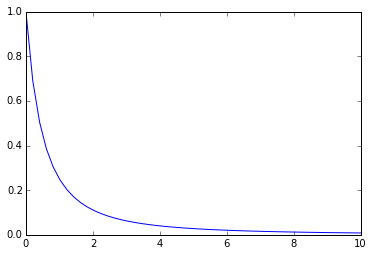

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

K_x = np.linspace(0, 10)
K_prior = lambda K: 1./(1. + K)**2
plt.plot(K_x, K_prior(K_x))

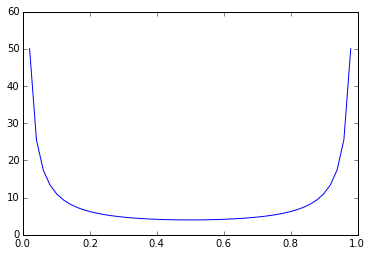

In [6]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

eta_x = np.linspace(0, 1)
eta_prior = lambda eta: 1./(eta*(1.-eta)) 
plt.plot(eta_x, eta_prior(eta_x))

Now, by multiplying these quantities together, we can obtain a non-normalized posterior.

$$p(K, \eta | \mathbf{y}) \propto \frac{1}{(1+K)^2} \frac{1}{\eta(1-\eta)} \prod_i \frac{B(K\eta+y_i, K(1-\eta) + n_i - y_i)}{B(K\eta, K(1-\eta))}$$

This can be calculated in Python as follows (log-transformed):

In [8]:
from scipy.special import betaln

def betabin_post(params, n, y):

    K, eta = params
    post = betaln(K*eta + y, K*(1.-eta) + n - y).sum()
    post -= len(y)*betaln(K*eta, K*(1.-eta))
    post -= np.log(eta*(1.-eta))
    post -= 2.*np.log(1.+K)
    
    return post
        
betabin_post((15000, 0.003), cancer.n, cancer.y)        

-605.06645607721157

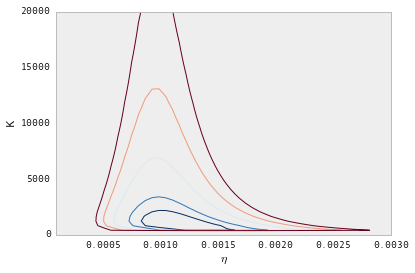

In [8]:
# Create grid
K_x = np.linspace(1, 20000)
eta_x = np.linspace(0.0001, 0.003)

# Calculate posterior on grid
z = np.array([[betabin_post((K, eta), cancer.n, cancer.y) 
               for eta in eta_x] for K in K_x])

# Plot posterior
x, y = np.meshgrid(eta_x, K_x)
cplot = plt.contour(x, y, z-z.max(), [-0.5, -1, -2, -3, -4], cmap=plt.cm.RdBu)
plt.ylabel('K');plt.xlabel('$\eta$');

To deal with the extreme skewness in the precision parameter $K$ and to facilitate modeling, we can transform the beta-binomial parameters to the real line via:

$$\begin{aligned}
\theta_1 &= \log(K) \cr
\theta_2 &= \log\left(\frac{\eta}{1-\eta}\right)
\end{aligned}$$

which we can easily implement by wrapping `betabin_post`:

In [10]:
def betabin_trans(theta, n, y):
    K = np.exp(theta[0])
    eta = 1./(1. + np.exp(-theta[1]))
    
    post = betaln(K*eta + y, K*(1.-eta) + n - y).sum()
    post -= len(y)*betaln(K*eta, K*(1.-eta))
    post += theta[0]
    post -= 2.*np.log(1.+np.exp(theta[0]))
    
    return post
    
betabin_trans((10, -7.5), cancer.n, cancer.y)

-576.79668610789224

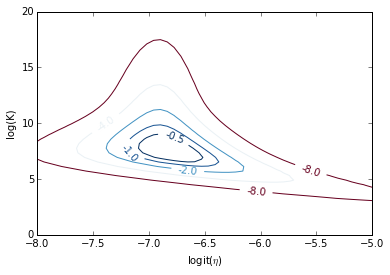

In [11]:
# Create grid
log_K_x = np.linspace(0, 20)
logit_eta_x = np.linspace(-8, -5)

# Calculate posterior on grid
z = np.array([[betabin_trans((t1, t2), cancer.n, cancer.y) 
             for t2 in logit_eta_x] for t1 in log_K_x])

# Plot posterior
x, y = np.meshgrid(logit_eta_x, log_K_x)
cplot = plt.contour(x, y, z - z.max(), [-0.5, -1, -2, -4, -8], cmap=plt.cm.RdBu)
plt.clabel(cplot, inline=1, fontsize=10, fmt='%1.1f')
plt.ylabel('log(K)');plt.xlabel('logit($\eta$)');

## Approximation Methods

An alternative approach to summarizing a $p$-dimensional posterior distribution involves estimating the mode of the posterior, and approximating the density as multivariate normal. If we consider the logarithm of the unnormalized joint posterior:

$$h(\theta | y) = \log[f(y|\theta) p(\theta)]$$

one way to approximate this function is to usd a second-order Taylor series expansion around the mode $\hat{\theta}$:

$$h(\theta | y) \approx h(\hat{\theta} | y) + \frac{1}{2}(\theta-\hat{\theta})' h''(\hat{\theta} | y) (\theta-\hat{\theta})$$

(Second term goes to 0 as mode is 0??)

This form is simply the multivariate normal distribution with $\hat{\theta}$ as the mean and the inverse negative Hessian as the covariance matrix:

$$\Sigma = -h''(\hat{\theta} | y)^{-1}$$

We can apply one of several numerical methods for multivariate optimization to numerically estimate the mode of the posterior. Here, we will use the Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm that is provided by SciPy. In addition to returning an estimate of the mode, it returns the estimated variance-covariance matrix, which we will need to parameterize the mutlivariate normal distribution.

Applying this to the beta-binomial posterior estimation problem, we simply provide an initial guess for the mode:

In [12]:
from scipy.optimize import fmin_bfgs

betabin_trans_min = lambda *args: -betabin_trans(*args)#the algorithm does minimization.

init_value = (10, -7.5)

opt = fmin_bfgs(betabin_trans_min, init_value, 
          args=(cancer.n, cancer.y), full_output=True)
mode, var = opt[0], opt[3]
mode, var

         Current function value: 571.376201
         Iterations: 8
         Function evaluations: 111
         Gradient evaluations: 25


(array([ 7.57755904, -6.81895461]), array([[ 0.73900145, -0.0309378 ],
        [-0.0309378 ,  0.05327216]]))

Thus, our approximated mode is $\log(K)=7.6$, $\text{logit}(\eta)=-6.8$. We can plug this value, along with the variance-covariance matrix, into a function that returns the kernel of a multivariate normal distribution, and use this to plot the approximate posterior:

In [14]:
det = np.linalg.det 
inv = np.linalg.inv

def lmvn(value, mu, Sigma):
    # Log kernel of multivariate normal
    delta = np.array(value) - mu
    return 1 / (2. * (np.log(det(Sigma))) - np.dot(delta.T, np.dot(inv(Sigma), delta)))

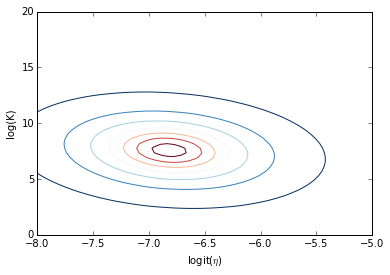

In [15]:
z = np.array([[lmvn((t1, t2), mode, var) 
             for t2 in logit_eta_x] for t1 in log_K_x])
x, y = np.meshgrid(logit_eta_x, log_K_x)
cplot = plt.contour(x, y, z - z.max(), cmap=plt.cm.RdBu)
plt.ylabel('log(K)');plt.xlabel('logit($\eta$)');

Along with this, we can estimate a 95% probability interval for the estimated mode:

In [17]:
#using normal percent point function??
from scipy.stats.distributions import norm

se = np.sqrt(np.diag(var))

mode[0] + norm.ppf(0.025)*se[0], mode[0] + norm.ppf(0.975)*se[0]

(5.8926722074382862, 9.2624458767123272)

In [18]:
mode[1] + norm.ppf(0.025)*se[1], mode[1] + norm.ppf(0.975)*se[1]

(-7.2713292270676435, -6.3665799967537682)

Of course, this approximation is only reasonable for posteriors that are not strongly skewed, bimodal, or leptokurtic (heavy-tailed). 
## NOTE
Difference between confidence interval interpretation in frequentist and bayesian approaches!!

## Rejection Sampling

Though Monte Carlo integration allows us to estimate integrals that are unassailable by analysis and standard numerical methods, it relies on the ability to draw samples from the posterior distribution. For known parametric forms, this is not a problem; probability integral transforms or bivariate techniques (e.g Box-Muller method) may be used to obtain samples from uniform pseudo-random variates generated from a computer. Often, however, we cannot readily generate random values from non-standard posteriors. In such instances, we can use rejection sampling to generate samples.

Posit a function, $f(x)$ which can be evaluated for any value on the support of $x:S_x = [A,B]$, but may not be integrable or easily sampled from. If we can calculate the maximum value of $f(x)$, we can then define a rectangle that is guaranteed to contain all possible values
$(x,f(x))$. It is then trivial to generate points over the box and enumerate the values that fall under the curve.


$$\begin{gathered}
\begin{split}\frac{\mbox{Points under curve}}{\mbox{Points generated}} \times \mbox{box area} = \lim_{n \to \infty} \int_A^B f(x) dx\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

### Example: triangular distribution

In [20]:
def rtriangle(low, high, mode):
    alpha = -1
    while np.random.random() > alpha:
        u = np.random.uniform(low, high)
        if u < mode:
            alpha = (u - low) / (mode - low)
        else:
            alpha = (high - u) / (high - mode)
    return(u)

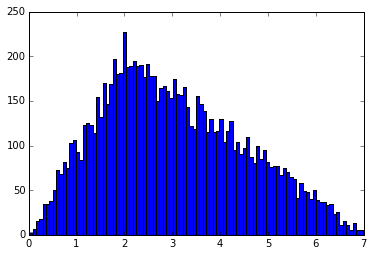

In [21]:
_ = plt.hist([rtriangle(0, 7, 2) for t in range(10000)], bins=100)

This approach is useful, for example, in estimating the normalizing constant for posterior distributions.


If $f(x)$ has unbounded support (i.e. infinite tails), such as a Gaussian distribution, a bounding box is no longer appropriate. We must specify a majorizing (or, enveloping) function, $g(x)$, which implies:

$$\begin{gathered}
\begin{split}cg(x) \ge  f(x) \qquad\forall x \in (-\infty,\infty)\end{split}\notag\\\begin{split}\end{split}\notag\end{gathered}$$

Having done this, we can now sample ${x_i}$ from $g(x)$ and accept or reject each of these values based upon $f(x_i)$. Specifically, for each draw $x_i$, we also draw a uniform random variate $u_i$ and accept $x_i$
if $u_i < f(x_i)/cg(x_i)$, where $c$ is a constant. This procedure is repeated until a sufficient number of samples is obtained. This approach is made more efficient by choosing an enveloping distribution that is “close” to the target distribution, thus maximizing the number of accepted points. 

To apply rejection sampling to the beta-binomial example, we first need to find a majorizing function $g(x)$ from which we can easily draw samples. We have seen in the previous section that the multivariate normal might serve as a suitable candidate, if multiplied by an appropriately large value of $c$. However, the thinness of the normal tails makes it difficult to use as a majorizing function. Instead, a multivariate Student's T distribution offers heavier tails for a suitably-small value for the degrees of freedom $\nu$:

$$f(\mathbf{x}| \nu,\mu,\Sigma) = \frac{\Gamma\left[(\nu+p)/2\right]}{\Gamma(\nu/2)\nu^{p/2}\pi^{p/2}\left|{\mathbf \Sigma}\right|^{1/2}\left[1+\frac{1}{\nu}({\mathbf x}-{\mu})^T{\mathbf \Sigma}^{-1}({\mathbf x}-{\mathbf \mu})\right]^{(\nu+p)/2}}$$

We can draw samples from a multivariate-T density by combining mutlivariate normal and $\chi^2$ random variates:

> ### Generating multivariate-T samples

> If $X$ is distributed multivariate normal $\text{MVN}(\mathbf{0},\Sigma)$ and $S$ is a $\chi^2$ random variable with $\mu$ degrees of freedom, then a multivariate Student's-T random variable $T = T_1,\ldots,T_p$ can be generated by $T_i = \frac{\sqrt{\nu}X_i}{S} + \mu_i$, where $\mu = \mu_1,\ldots,\mu$ is a mean vector.

This is implemented in Python by:

In [23]:
chi2 = np.random.chisquare
mvn = np.random.multivariate_normal

rmvt = lambda nu, S, mu=0, size=1: (np.sqrt(nu) * (mvn(np.zeros(len(S)), S, size).T
                                   / chi2(nu, size))).T + mu

Finally, we need an implementation of the multivariate T probability distribution function, which is as follows:

In [24]:
from scipy.special import gammaln

def mvt(x, nu, S, mu=0): 

    d = len(S)
    n = len(x)
    X = np.atleast_2d(x) - mu
    
    Q = X.dot(np.linalg.inv(S)).dot(X.T).sum()
    log_det = np.log(np.linalg.det(S))
    log_pdf = gammaln((nu + d)/2.) - 0.5 * (d*np.log(np.pi*nu) + log_det) - gammaln(nu/2.)
    log_pdf -= 0.5*(nu + d)*np.log(1 + Q/nu)
    
    return(np.exp(log_pdf))

The next step is to find the constant $c$ that ensures:

$$cg(\theta) \ge  f(\theta|y) \qquad\forall \theta \in (-\infty,\infty)$$

Alternatively, we want to ensure:

$$\log[f(\theta|y)] - \log[g(\theta)] \le c'$$

In [25]:
def calc_diff(theta, n, y, nu, S, mu):
    
    return betabin_trans(theta, n, y) - np.log(mvt(theta, nu, S, mu))

calc_diff_min = lambda *args: -calc_diff(*args)

We can calculate an appropriate value of $c'$ by simply using the approximation method described above on `calc_diff` (tweaked to produce a negative value for minimization):

In [26]:
opt = fmin_bfgs(calc_diff_min, 
                (12, -7), 
                args=(cancer.n, cancer.y, 4, 2*var, mode), 
                full_output=True)

         Current function value: 568.710236
         Iterations: 7
         Function evaluations: 118
         Gradient evaluations: 24


In [27]:
c = opt[1]
c

568.71023574733351

Now we can execute a rejection sampling algorithm:

In [28]:
def reject(post, nu, S, mu, n, data, c):
    
    k = len(mode)
    
    # Draw samples from g(theta)
    theta = rmvt(nu, S, mu, size=n)
    
    # Calculate probability under g(theta)
    gvals = np.array([np.log(mvt(t, nu, S, mu)) for t in theta])

    # Calculate probability under f(theta)
    fvals = np.array([post(t, data.n, data.y) for t in theta])
    
    # Calculate acceptance probability
    p = np.exp(fvals - gvals + c)
    
    return theta[np.random.random(n) < p]

In [29]:
nsamples = 1000
sample = reject(betabin_trans, 4, var, mode, nsamples, cancer, c)

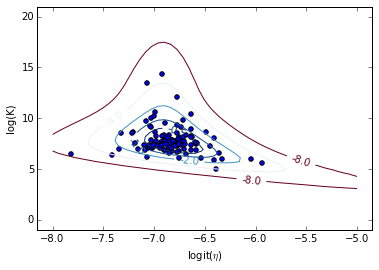

In [30]:
z = np.array([[betabin_trans((t1, t2), cancer.n, cancer.y) 
             for t2 in logit_eta_x] for t1 in log_K_x])
x, y = np.meshgrid(logit_eta_x, log_K_x)
cplot = plt.contour(x, y, z - z.max(), [-0.5, -1, -2, -4, -8], cmap=plt.cm.RdBu)
plt.clabel(cplot, inline=1, fontsize=10, fmt='%1.1f')
plt.ylabel('log(K)');plt.xlabel('logit($\eta$)')
plt.scatter(*sample.T[[1,0]])

Notice that the efficiency of rejection sampling is not very high for this problem.

In [31]:
float(sample.size)/nsamples

0.268

Rejection sampling is usually subject to declining performance as the dimension of the parameter space increases. Further improvement is gained by using optimized algorithms such as importance sampling which, as the name implies, samples more frequently from important areas of the distribution.

## Importance Sampling

As we have seen, the primary difficulty in Bayesian inference is calculating the posterior density for models of moderate-to-high dimension. For example, calculating the posterior mean of some function $h$ requires two difficult integration steps:

$$E[h(\theta) | y] = \frac{\int h(\theta)f(y|\theta) p(\theta) d\theta}{\int f(y|\theta) p(\theta) d\theta} = \frac{\int h(\theta)p(\theta | y) d\theta}{\int p(\theta|y) d\theta}$$

If the posterior $p(\theta|y)$ is a density from which it is easy to sample, we could approximiate these integrals using Monte Carlo simulation, but too often it is not.

Instead, assume that we can draw from a probability density $q(\theta)$ that is some approximation of $p$. We could then write:

$$E[h(\theta) | y] = \frac{\int h(\theta) \frac{p(\theta|y)}{q(\theta)} q(\theta) d\theta}{\int \frac{p(\theta|y)}{q(\theta)} q(\theta) d\theta}$$

Expressed this way, $w(\theta) = p(\theta|y) / q(\theta)$ can be regarded as *weights* for the $M$ values of $\theta$ sampled from $q$ that we can use to correct the sample so that it approximates $h(\theta)$. Specifically, the **importance sampling estimate** of $E[h(\theta) | y]$ is:

$$\hat{h}_{is} = \frac{\sum_{i=1}^{M} h(\theta^{(i)})w(\theta^{(i)})}{\sum_{i=1}^{M} w(\theta^{(i)})}$$

where $\theta^{(i)}$ is the $i^{th}$ sample simulated from $q(\theta)$. The standard error for the importance sampling estimate is:

$$\text{SE}_{is} = \frac{\sqrt{\sum_{i=1}^{M} [(h(\theta^{(i)}) - \hat{h}_{is}) w(\theta^{(i)})]^2}}{\sum_{i=1}^{M} w(\theta^{(i)})}$$

The efficiency of importance sampling is related to the selection of the importance sampling distribution $q$.

### Example: Beta-binomial parameter

As a simple illustration of importance sampling, let's consider again the problem of estimating the paramters of the beta-binomial example. Here, we will use a multivariate T density as the simulation distribution $q$.

Here are 1000 sampled values to use for approximating the posterior:

In [32]:
theta = rmvt(4, var, mode, size=1000)

We can obtain the probability of these values under the posterior density:

In [33]:
f_theta = np.array([betabin_trans(t, cancer.n, cancer.y) for t in theta])

and under the T distribution:

In [34]:
q_theta = mvt(theta, 4, var, mode)

This allows us to calculate the importance weights:

In [35]:
w = np.exp(f_theta - q_theta - max(f_theta - q_theta))

notice that we have subtracted the maximum value of the differences, which normalizes the weights.

Now, we can obtain estimates of the parameters:

In [37]:
theta_si = [(w*t).sum()/w.sum() for t in theta.T]
theta_si

[7.6143642953924529, -6.8206792194866939]

Finally, the standard error of the estimates:

In [38]:
se = [np.sqrt((((theta.T[i] - theta_si[i])* w)**2).sum()/w.sum()) for i in (0,1)]
se

[0.38053628852947557, 0.092233892849233043]

## Sampling Importance Resampling

The importance sampling method can be modified to incorporate weighted bootstrapping, in a procedure called sampling importance resampling (SIR). As previously, we obtain a sample of size $M$ from an importance sampling distribution $q$ and calculate the corresponding weights $w(\theta_i) = p(\theta|y) / q(\theta)$. 

Instead of directly re-weighting the samples from $q$, SIR instead transforms the weights into probabilities via:

$$p_i = \frac{w(\theta_i)}{\sum_{i=1}^M w(\theta_i)}$$

These probabilities are then used to re-sample their respective $\theta_i$ values, with replacement. This implies that the resulting resamples $\theta_i^{\prime}$ will be distributed approximately as the posterior $p(\theta|y)$.

Using again the beta-binomial example, we can take the weights calculated above, and convert them to probabilities:

In [40]:
p_sir = w/w.sum()

The `choice` function in `numpy.random` can be used to generate a random sample from an arbitrary 1-D array.

In [41]:
theta_sir = theta[np.random.choice(range(len(theta)), size=10000, p=p_sir)]

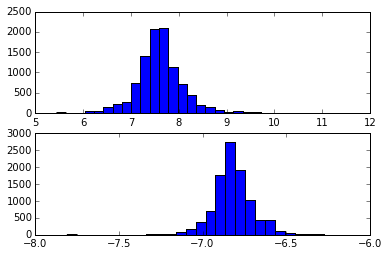

In [42]:
fig, axes = plt.subplots(2)
_ = axes[0].hist(theta_sir.T[0], bins=30)
_ = axes[1].hist(theta_sir.T[1], bins=30)

One advantage of this approach is that one can easily extract a posterior probability interval for each parameter, simply by extracting quantiles from the resampled values.

In [36]:
logK_sample = theta_sir[:,0]
logK_sample.sort()
logK_sample[[250, 9750]]

array([ 6.6943401 ,  8.46652309])

## Exercise: Sensitivity analysis

Perform a Bayesian sensitivity analysis by performing SIR on the stomach cancer dataset $N$ times, with one observation (a city) removed from the dataset each time. Calculate and plot posterior medians and 95% posterior intervals for each $f(\theta|y_{(-i)})$ to visually analyze the influence of each observation.

## References

Chapter 6 of [Givens, Geof H.; Hoeting, Jennifer A. (2012-10-09). Computational Statistics (Wiley Series in Computational Statistics)](http://www.stat.colostate.edu/computationalstatistics/)

Chapter 5 of [Albert, J. (2009). Bayesian computation with R.](http://www.amazon.com/Bayesian-Computation-R-Use/dp/0387922970)

---

In [38]:
from IPython.core.display import HTML
def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()